In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import awkward as ak
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Import Pythia Dataset

In [2]:
with uproot.open("/home/lvaughan/Pythia/event_based/dataset_mu60.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    trk_pt = f["trk_pT"].array()
    trk_eta = f["trk_eta"].array()
    trk_phi = f["trk_phi"].array()
    trk_q = f["trk_q"].array()
    trk_d0 = f["trk_d0"].array()
    trk_z0 = f["trk_z0"].array()
    trk_label = f["trk_label"].array()
    jet_trk_IDX = f["jet_track_index"].array()

### Associate Tracks to Jets

In [3]:
%%time
num_events = len(jet_pt)
trk_feats = []
for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    idx_list = list(jet_trk_IDX[event])
    idx_list.append(len(trk_pt[event]))
    
    jet_trk_feats = []
    for i in range(len(idx_list)-1):
        start_idx = idx_list[i]
        end_idx = idx_list[i+1]-1 
        trk_pt_tmp = np.array(trk_pt[event][start_idx:end_idx])
        trk_eta_tmp = np.array(trk_eta[event][start_idx:end_idx])
        trk_phi_tmp = np.array(trk_phi[event][start_idx:end_idx])
        trk_q_tmp = np.array(trk_q[event][start_idx:end_idx])
        trk_d0_tmp = np.array(trk_d0[event][start_idx:end_idx])
        trk_z0_tmp = np.array(trk_z0[event][start_idx:end_idx])
        trk_label_tmp = np.array(trk_label[event][start_idx:end_idx])

        feats = [trk_pt_tmp, trk_eta_tmp, trk_phi_tmp, trk_q_tmp,
                trk_d0_tmp, trk_z0_tmp, trk_label_tmp]
        feats = np.stack(feats, axis=-1)
        jet_trk_feats.append(feats)
    
    trk_feats.append(jet_trk_feats)
    
trk_feats = ak.Array(trk_feats)

print("Processing: ", num_events, " / ", num_events)
print("Num Events: ", len(trk_feats))
print("Num Jets in first event: ", len(trk_feats[0]))
print("Num Tracks in first event first jet: ", len(trk_feats[0][0]))
print("Num Tracks features: ", len(trk_feats[0][0][0]))

Processing:  1000  /  1000
Num Events:  1000
Num Jets in first event:  22
Num Tracks in first event first jet:  82
Num Tracks features:  7
CPU times: user 22.8 s, sys: 147 ms, total: 22.9 s
Wall time: 22.8 s


In [4]:
%%time
num_events = len(jet_pt)
jet_feats = []
for event in range(num_events):
    jet_pt_tmp = np.array(jet_pt[event])
    jet_eta_tmp = np.array(jet_eta[event])
    jet_phi_tmp = np.array(jet_phi[event])

    feats = [jet_pt_tmp, jet_eta_tmp, jet_phi_tmp]
    feats = np.stack(feats, axis=-1)
    
    jet_feats.append(feats)
    
jet_feats = ak.Array(jet_feats)

print(jet_feats)
print("Num Events: ", len(jet_feats))
print("Num Jets in first event: ", len(jet_feats[0]))
print("Num Jet Features: ", len(jet_feats[0][0]))

[[[146, -0.157, 2.52], [113, ..., 0.0962], ..., [26.7, -2.63, 4.82]], ...]
Num Events:  1000
Num Jets in first event:  22
Num Jet Features:  3
CPU times: user 507 ms, sys: 15 ms, total: 522 ms
Wall time: 510 ms


### Define Jet Class

In [5]:
class Jet:
    def __init__(self, jet_features, trk_features, trk_labels):
        self.jet_features = jet_features
        self.trk_features = trk_features
        self.trk_labels = trk_labels
        
    def get_label(self):
        sum_pt_hs = 0
        sum_pt_pu = 0.0000001
        for trk in range(len(self.trk_features)):
            if self.trk_labels[trk]==-1:
                sum_pt_hs+=self.trk_features[trk,0]**2
            else:
                sum_pt_pu+=self.trk_features[trk,0]**2
        return sum_pt_hs / (sum_pt_hs + sum_pt_pu)
    
    def set_label(self, label):
        self.label = np.float32(label)
        
    def set_binary_label(self):
        if self.label == 0:
            self.binary_label = np.float32(0)
        else:
            self.binary_label = np.float32(1)
        
    def convert_to_tensor(self):
        self.trk_features = torch.from_numpy(self.trk_features)
        self.jet_features = torch.from_numpy(self.jet_features)
        self.label = torch.tensor(self.label).reshape([1])
        self.binary_label = torch.tensor(self.binary_label).reshape([1])
        
    def norm_data(self, jet_means, trk_means, jet_stds, trk_stds):
        self.jet_features = torch.div(torch.sub(self.jet_features,jet_means),jet_stds)
        self.trk_features = torch.div(torch.sub(self.trk_features,trk_means),trk_stds)

### Apply Cuts, Read data into Jet class, and store on Event Basis

CPU times: user 1min 14s, sys: 197 ms, total: 1min 14s
Wall time: 1min 13s


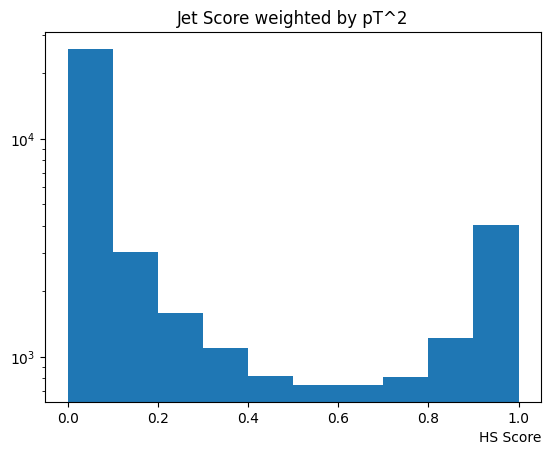

In [6]:
%%time     
Event_Jet_List = []
num_events = len(jet_pt)
for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    Jet_List = []
    num_jets = len(jet_feats[event])
    jet_eta_cut = jet_feats[event]
    for jet in range(num_jets):
        if abs(jet_feats[event][jet][1])>4:
            continue
        
        trk_q_cut = trk_feats[event][jet][:,3]!=0
        trk_eta_cut = abs(trk_feats[event][jet][:,1])<4
        trk_pt_cut = trk_feats[event][jet][:,0]>0.4
        
        mask = trk_q_cut & trk_eta_cut & trk_pt_cut
        #not_mask = ~mask
        
        pass_trks = trk_feats[event][jet][mask]
        #fail_trks = trk_feats[event][jet][not_mask]
        
        jet_f = np.array(jet_feats[event][jet], dtype=np.float32)
        trk_f = np.array(pass_trks[:,0:3], dtype=np.float32)
        trk_l = np.array(pass_trks[:,-1], dtype=np.float32)
        
        Jet_List.append(Jet(jet_f,trk_f,trk_l))
        
    Event_Jet_List.append(Jet_List)

label = []
for event in range(num_events):
    for jet in Event_Jet_List[event]:
        jet.set_label(jet.get_label())
        jet.set_binary_label()
        jet.convert_to_tensor()
        
        # List for plotting labels
        label.append(float(jet.label))
    
plt.hist(label)
plt.title("Jet Score weighted by pT^2")
plt.xlabel("HS Score",loc='right')
plt.yscale('log')

### Generate Track Tensor

In [7]:
%%time
# Apply Cuts on Tracks
pt_cut = (trk_pt > 0.4)
eta_cut = ((trk_eta < 4) & (trk_eta > -4))
q_cut = (trk_q != 0)
mask = q_cut & eta_cut & pt_cut
pt_trk = trk_pt[mask]
eta_trk = trk_eta[mask]
phi_trk = trk_phi[mask]
    
# Loop over Events and store tracks as torch tensor
Event_Track_List = []
for i in range(num_events):
    trk_pt_tmp = torch.reshape(torch.Tensor(pt_trk[i]),(-1,1))
    trk_eta_tmp = torch.reshape(torch.Tensor(eta_trk[i]),(-1,1))
    trk_phi_tmp = torch.reshape(torch.Tensor(phi_trk[i]),(-1,1))
    
    trk_feats = torch.cat([trk_pt_tmp, trk_eta_tmp, trk_phi_tmp],1)
    Event_Track_List.append(trk_feats)

CPU times: user 2.39 s, sys: 1.93 ms, total: 2.39 s
Wall time: 2.39 s


### Generate Jet Tensor

In [8]:
%%time
Jet_Event_List = []
Jet_Label_List = []
for i in range(num_events):
    jet_feats = []
    jet_labels = []
    for j in range(len(Event_Jet_List[i])):
        jet_feats_tmp = torch.reshape(Event_Jet_List[i][j].jet_features,(1,3))
        jet_feats.append(jet_feats_tmp)
        
        jet_labels.append(Event_Jet_List[i][j].label)
        
        
    jet_feats = torch.cat(jet_feats, 0)
    Jet_Event_List.append(jet_feats)
    
    jet_labels = torch.reshape(torch.cat(jet_labels, 0),(-1,1))
    Jet_Label_List.append(jet_labels)
    
print(Jet_Event_List[0].shape)
print(Jet_Label_List[0].shape)

torch.Size([19, 3])
torch.Size([19, 1])
CPU times: user 48.3 ms, sys: 982 μs, total: 49.2 ms
Wall time: 48.8 ms


In [9]:
Event_List = list(zip(Jet_Event_List,Event_Track_List,Jet_Label_List))
random.shuffle(Event_List)

Events_training = Event_List[0:int(0.6*num_events)]
Events_validation = Event_List[int(0.6*num_events):int(0.7*num_events)]
Events_testing = Event_List[int(0.7*num_events):]

print("Processing: ", num_events, " / ", num_events)
print("Training Events: ", len(Events_training))
print("Validation Events: ", len(Events_validation))
print("Testing Events: ", len(Events_testing))

1000
Processing:  1000  /  1000
Training Events:  600
Validation Events:  100
Testing Events:  300


In [10]:
print(len(Events_training[0]))
print(Events_training[0][0].shape)
print(Events_training[0][1].shape)
print(Events_training[0][2].shape)

3
torch.Size([23, 3])
torch.Size([406, 3])
torch.Size([23, 1])


### Define Model

In [11]:
class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 16
        self.num_heads = 1
        self.num_jet_feats = 3
        self.num_trk_feats = 3
        
        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
                
        self.multihead_attn = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)
        
        self.regression = nn.Linear(self.embed_dim, 1)
        
    def forward(self, jets, trks):
        # Feature preprocessing layers
        trk_init = F.relu(self.trk_initializer(trks))
        jet_init = F.relu(self.jet_initializer(jets))
        
        # Calculate updated jet embedding from context of tracks
        query = jet_init
        key = trk_init
        value = trk_init
        
        jet_embedding, weights = self.multihead_attn(query, key, value)
        
        # Get two outputs
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output, weights

In [12]:
model = Model()
print(model)
output, weights = model(Events_training[0][0],Events_training[0][1])
print()
print(output.shape)
print(weights.shape)

Model(
  (jet_initializer): Linear(in_features=3, out_features=16, bias=True)
  (trk_initializer): Linear(in_features=3, out_features=16, bias=True)
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (regression): Linear(in_features=16, out_features=1, bias=True)
)

torch.Size([23, 1])
torch.Size([23, 406])


### Define Training Loop

In [13]:
def train(model, data, epochs=100):
    train_data, validation_data = data
    
    combined_history = []
    mse_history = []
    bce_history = []
    
    num_train = len(Events_training)
    num_val = len(Events_validation)
    
    for e in range(epochs):
        model.train()
        cumulative_MSE_train = 0
        cumulative_BCE_train = 0
        cumulative_loss_train = 0

        for i in range(num_train):
            jets_train, trks_train, train_labels, train_bin_labels = dataloader(Events_training[i])
    
            optimizer.zero_grad()
            
            output, binary, weights_jet, weight_trk = model(jets_train.to(device), trks_train.to(device))
            
            loss_MSE=loss_fn1(output, train_labels.to(device))
            loss_BCE=loss_fn2(binary, train_bin_labels.to(device))
            loss = ALPHA * loss_MSE + BETA * loss_BCE
            
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            cumulative_MSE_train+=loss_MSE.detach().cpu().numpy().mean()
            cumulative_BCE_train+=loss_BCE.detach().cpu().numpy().mean()

        cumulative_loss_train = cumulative_loss_train / num_train
        cumulative_MSE_train = cumulative_MSE_train / num_train
        cumulative_BCE_train = cumulative_BCE_train / num_train

        
        model.eval()
        cumulative_MSE_val = 0
        cumulative_BCE_val = 0
        cumulative_loss_val = 0
        for i in range(num_val):
            jets_val, trks_val, val_labels, val_bin_labels = dataloader(Events_validation[i])
            output, binary, jet_weights, trk_weights = model(jets_val.to(device), trks_val.to(device))
            loss_MSE=loss_fn1(output, val_labels.to(device))
            loss_BCE=loss_fn2(binary, val_bin_labels.to(device))
            loss = ALPHA * loss_MSE + BETA * loss_BCE
            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
            cumulative_MSE_val+=loss_MSE.detach().cpu().numpy().mean()
            cumulative_BCE_val+=loss_BCE.detach().cpu().numpy().mean()
            
        cumulative_loss_val = cumulative_loss_val / num_val
        cumulative_MSE_val = cumulative_MSE_val / num_val
        cumulative_BCE_val = cumulative_BCE_val / num_val

        
        combined_history.append([cumulative_loss_train, cumulative_loss_val])
        mse_history.append([cumulative_MSE_train, cumulative_MSE_val])
        bce_history.append([cumulative_BCE_train, cumulative_BCE_val])

        if e%1==0:
            print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))

    return np.array(combined_history), np.array(mse_history), np.array(bce_history)

### Train Model

In [14]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

model = Model()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0000005)

loss_fn1 = nn.MSELoss()
loss_fn2 = nn.BCELoss()

# Combined Loss = ALPHA * MSE + BETA * BCE
ALPHA = 1    # Weight of MSE Loss
BETA = 0    # Weight of BCE Loss

combined_history, mse_history, bce_history = train(model, [Events_training, Events_validation])

plt.plot(combined_history[:,0], label="Train Combined")
plt.plot(combined_history[:,1], label="Val Combined")
plt.title('Combined Loss')
plt.legend()
plt.show()
#plt.plot(mse_history[:,0], label="Train MSE")
#plt.plot(mse_history[:,1], label="Val MSE")
#plt.title('MSE Loss')
#plt.legend()
#plt.show()
#plt.plot(bce_history[:,0], label="Train BCE")
#plt.plot(bce_history[:,1], label="Val BCE")
#plt.title('BCE Loss')
#plt.legend()
#plt.show()

GPU Available:  True
cuda:0



NameError: name 'dataloader' is not defined

### Evaluate Model

In [ ]:
model.eval()
cumulative_loss_test = 0
cumulative_MSE_test = 0
cumulative_BCE_test = 0
predicted_labels = []
true_labels = []
binary_pred = []
binary_true = []

num_test = len(Events_testing)
for i in range(num_test):
    jets_test, trks_test, test_labels, test_bin_labels = dataloader(Events_testing[i])
    output, binary, jet_weights, trk_weights = model(jets_test.to(device), trks_test.to(device))
    
    loss_MSE=loss_fn1(output, test_labels.to(device))
    loss_BCE=loss_fn2(binary, test_bin_labels.to(device))
    loss = ALPHA * loss_MSE + BETA * loss_BCE
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
    cumulative_MSE_test+=loss_MSE.detach().cpu().numpy().mean()
    cumulative_BCE_test+=loss_BCE.detach().cpu().numpy().mean()
        
    for j in range(output.shape[0]): 
        predicted_labels.append(1-float(output[j][0].detach().cpu().numpy()))
        true_labels.append(1-float(test_labels[j][0].detach().numpy()))
        binary_pred.append(1-float(binary[j][0].detach().cpu().numpy()))
        binary_true.append(1-float(test_bin_labels[j][0].detach().numpy()))
    
cumulative_loss_test = cumulative_loss_test / num_test
cumulative_MSE_test = cumulative_MSE_test / num_test
cumulative_BCE_test = cumulative_BCE_test / num_test
    
print("Train Loss:\t", combined_history[-1][0])
print("Val Loss:\t", combined_history[-1][1])
print("Test Loss:\t", cumulative_loss_test)
print()
print("Test MAE:\t", mean_absolute_error(true_labels, predicted_labels))
print("Test RMSE:\t", root_mean_squared_error(true_labels, predicted_labels))

plt.hist(true_labels,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(predicted_labels,histtype='step',color='b',label='Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()

binary_true = np.array(binary_true)
binary_pred = np.array(binary_pred)
PU_idxs = np.where(binary_true == 1)
HS_idxs = np.where(binary_true == 0)

#plt.hist(binary_true,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
#plt.hist(binary_pred[HS_idxs],histtype='step',color='g',label='HS Predicted Distribution',bins=50,range=(0,1))
#plt.hist(binary_pred[PU_idxs],histtype='step',color='b',label='PU Predicted Distribution',bins=50,range=(0,1))
#plt.title("Predicted Binary Ouput Distribution using Attention Model (\u03BC=60)")
#plt.legend()
#plt.yscale('log')
#plt.xlabel('PU Fraction',loc='right')
#plt.show()

### Visualize Attention Scores

In [ ]:
plot_events=1
for i in range(plot_events):
    
    jets_test, trks_test, test_labels, test_bin_labels = dataloader(Events_testing[i])
    
    # Get Model Predictions
    model.eval()
    output, binary, jet_weights, trk_weights = model(jets_test.to(device), trks_test.to(device))
    
    num_jets = len(output)
    
    ticks = [x for x in range(num_jets)]
    jet_labels= [round(float(label.detach().cpu().numpy()[0]),2) for label in test_labels]   

    fig, (ax1) = plt.subplots(1, 1, figsize=(15,15))
    im0 = ax1.imshow(jet_weights.detach().cpu().numpy())
    ax1.set_xticks(ticks, jet_labels)
    ax1.set_yticks(ticks, jet_labels)
    ax1.set_title("Attention Scores Between Jets")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')
    
    # Calculate tick labels
    num_trks = len(Events_testing[i][0].trk_features)
    for j in range(num_jets):
        # Define subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
        tick_labels = []
        num_trks = len(Events_testing[i][j].trk_labels)
        ticks = [x for x in range(num_trks)]
        for trk in range(num_trks):
            tick_labels.append(int(Events_testing[i][j].trk_labels[trk]))
    
        # Plot attention weights
        #im1 = ax1.imshow(trk_weights[j].detach().cpu().numpy())
        im1 = ax1.imshow(trk_weights[j][0:num_trks,0:num_trks].detach().cpu().numpy())
        ax1.set_xticks(ticks, tick_labels)
        ax1.set_yticks(ticks, tick_labels)
        ax1.set_title("Attention Scores Between Tracks\nJet Score="+str(jet_labels[j]))
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')

        # Calculate cos similiarity matrix
        cos_sim_matrix = np.zeros((num_trks,num_trks))
        for u in range(num_trks):
            feats1 = Events_testing[i][j].trk_features[u].numpy()
            A = np.linalg.norm(feats1)
            for v in range(u,num_trks):
                feats2 = Events_testing[i][j].trk_features[v].numpy()
                B = np.linalg.norm(feats2)
                cos_sim_matrix[u,v] = np.dot(feats1,feats2) / (A*B)
                cos_sim_matrix[v,u] = cos_sim_matrix[u,v]
                #print(feats1)
                #print(feats2)
                #print(np.dot(feats1,feats2) / (A*B))
            #print()

        # Plot cos similiarity matrix
        im2 = ax2.imshow(cos_sim_matrix)  
        ax2.set_xticks(ticks, tick_labels)
        ax2.set_yticks(ticks, tick_labels)
        ax2.set_title("Cos Similarity Between Tracks")
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax, orientation='vertical')

        plt.show()    